# Determining which points are in boxes

Primary function:
 - all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)

Input:
 - qq: $N \times d$ array of points (each row is a point)
 - box_mins: $M \times d$ array of "minimum corner" points for $M$ boxes
 - box_maxes: $M \times d$ array of "maximum corner" points for $M$ boxes
 
Output:
 - all_box_inds: length $M$ list of lists
   - all_box_inds[i] = list of indices j such that qq[j,:] is in box i
 
Other:
 - $N=$ number of points
 - $M=$ number of boxes
 - $d=$ spatial dimension
 
For example, the unit cube has minimum corner point $(0,0,0)$ and maximum corner point $(1,1,1)$

### Fancy method
Algorithm:
 1. Sort points in each of the coordinate directions (x,y,z,...)
 2. Given a box, for each coordinate direction, find the points that are within the bounds for that direction, using fast 1d sorted search (e.g., numpy's searchsorted uses binary search)
 3. The points in the box are the intersection of the sets of points that are within the bounds for each coordinate direction.
 
 Algorithm idea was told to me by J.J. Alger

In [1]:
import numpy as np
import numba as nb # <--- Remove if you don't have numba

@nb.njit # <--- Remove if you don't have numba
def intersection_of_many_sets(SS):
    S_intersection = set(SS[0])
    for k in range(1,len(SS)):
#         S_intersection = np.intersect1d(S_intersection, SS[k]) # np.intersect1d not supported in numba
        S_intersection = S_intersection.intersection(set(SS[k]))
    return list(S_intersection)

@nb.njit # <--- Remove if you don't have numba
def get_inds_in_boxes(qq, box_mins, box_maxes):
    # See: https://github.com/NickAlger/helper_functions/blob/master/points_in_boxes.ipynb
    N, d = box_mins.shape
    
    qq_cartesian_sort_inds = [np.argsort(qq[:,k]) for k in range(d)]
    qq_cartesian_sorts = [qq[qq_cartesian_sort_inds[k],k] for k in range(d)]
    
    ll = np.empty((N,d))
    rr = np.empty((N,d))
    for k in range(d):
        ll[:,k] = np.searchsorted(qq_cartesian_sorts[k], box_mins[:,k])
        rr[:,k] = np.searchsorted(qq_cartesian_sorts[k], box_maxes[:,k])

    all_box_inds = list()
    for i in range(N):
        
        candidate_inds_by_dim = list()
        for k in range(d):
            candidate_inds_by_dim.append(qq_cartesian_sort_inds[k][ll[i,k] : rr[i,k]])
            
        inds_in_ith_box = intersection_of_many_sets(candidate_inds_by_dim)
        all_box_inds.append(inds_in_ith_box)
        
    return all_box_inds

### Brute force method

In [2]:
@nb.njit # <--- Remove if you don't have numba
def get_inds_in_boxes_brute(qq, box_mins, box_maxes):
    N, d = box_mins.shape

    all_box_inds = list()
    for i in np.arange(N):
#         box_inds = np.all(box_mins[i,:] <= qq, axis=-1) * np.all(qq < box_maxes[i,:], axis=-1) # not supported in numba
        box_inds = (np.sum(box_mins[i,:] <= qq, axis=-1) >= d) * (np.sum(qq < box_maxes[i,:], axis=-1) >= d)
        all_box_inds.append(list(box_inds))
        
    return all_box_inds

## Test / example usage

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from time import time

### Set up points and boxes

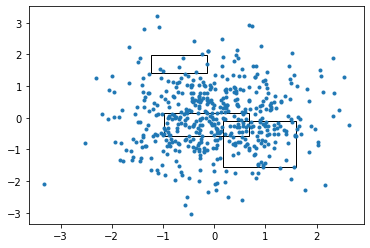

In [4]:
num_pts = 500
num_boxes = 3
qq = np.random.randn(num_pts,2)

box_points = np.random.randn(num_boxes, 2)
box_mins = box_points - np.random.rand(*box_points.shape)
box_maxes = box_points + np.random.rand(*box_points.shape)

deltas = box_maxes - box_mins
widths = deltas[:,0]
heights = deltas[:,1]

plt.plot(qq[:,0], qq[:,1], '.')
ax = plt.gca()
for i in range(num_boxes):
    rect = patches.Rectangle(tuple(box_mins[i,:]), widths[i], heights[i], linewidth=1, edgecolor='k',facecolor='none')
    ax.add_patch(rect)

### Use get_inds_in_boxes()

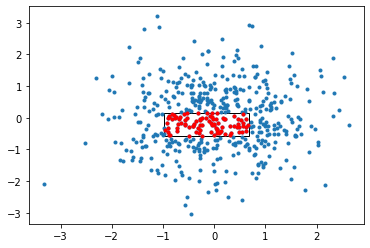

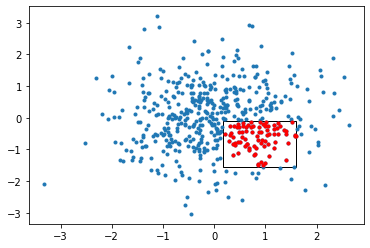

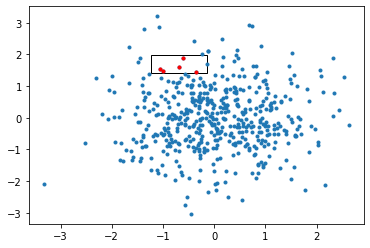

In [5]:
all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)

for i in range(num_boxes):
    plt.figure()
    plt.plot(qq[:,0], qq[:,1], '.')
    
    qq_in_box = qq[all_box_inds[i], :]
    plt.plot(qq_in_box[:,0], qq_in_box[:,1], '.r')
    
    ax = plt.gca()
    rect = patches.Rectangle(tuple(box_mins[i,:]), widths[i], heights[i], linewidth=1, edgecolor='k',facecolor='none')
    ax.add_patch(rect)

### Use get_inds_in_boxes_brute()

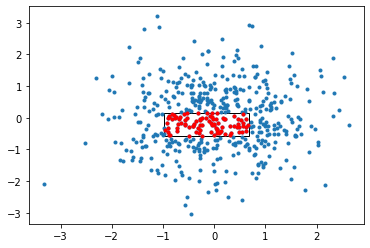

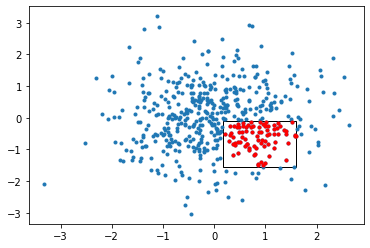

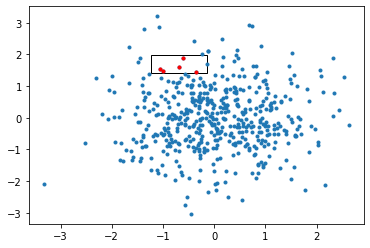

In [6]:
all_box_inds_brute = get_inds_in_boxes_brute(qq, box_mins, box_maxes)

for i in range(num_boxes):
    plt.figure()
    plt.plot(qq[:,0], qq[:,1], '.')
    
    qq_in_box = qq[all_box_inds_brute[i], :]
    plt.plot(qq_in_box[:,0], qq_in_box[:,1], '.r')
    
    ax = plt.gca()
    rect = patches.Rectangle(tuple(box_mins[i,:]), widths[i], heights[i], linewidth=1, edgecolor='k',facecolor='none')
    ax.add_patch(rect)

## Compare timing of fancy vs. brute force methods

### Many points, few boxes

In [7]:
num_pts = 1000000
num_boxes = 5
qq = np.random.randn(num_pts,2)

box_points = np.random.randn(num_boxes, 2)
box_mins = box_points - np.random.rand(*box_points.shape)
box_maxes = box_points + np.random.rand(*box_points.shape)

t = time()
all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)
dt_fancy = time() - t
print('dt_fancy=', dt_fancy)

t = time()
all_box_inds_brute = get_inds_in_boxes_brute(qq, box_mins, box_maxes)
dt_brute = time() - t
print('dt_brute=', dt_brute)

dt_fancy= 0.5934057235717773
dt_brute= 0.12901043891906738


## Many boxes, few points

In [8]:
num_pts = 100
num_boxes = 100000
qq = np.random.randn(num_pts,2)

box_points = np.random.randn(num_boxes, 2)
box_mins = box_points - np.random.rand(*box_points.shape)
box_maxes = box_points + np.random.rand(*box_points.shape)

t = time()
all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)
dt_fancy = time() - t
print('dt_fancy=', dt_fancy)

t = time()
all_box_inds_brute = get_inds_in_boxes_brute(qq, box_mins, box_maxes)
dt_brute = time() - t
print('dt_brute=', dt_brute)

dt_fancy= 0.45713353157043457
dt_brute= 0.6443359851837158


### Many boxes many points

In [9]:
num_pts = 2000
num_boxes = 50000
qq = np.random.randn(num_pts,2)

box_points = np.random.randn(num_boxes, 2)
box_mins = box_points - np.random.rand(*box_points.shape)
box_maxes = box_points + np.random.rand(*box_points.shape)

t = time()
all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)
dt_fancy = time() - t
print('dt_fancy=', dt_fancy)

t = time()
all_box_inds_brute = get_inds_in_boxes_brute(qq, box_mins, box_maxes)
dt_brute = time() - t
print('dt_brute=', dt_brute)

dt_fancy= 1.112248182296753
dt_brute= 3.3005900382995605


## Timing comparison for boundary points

dt_fancy= 0.9040868282318115
dt_brute= 3.639615058898926


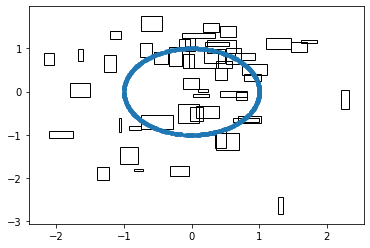

In [10]:
num_pts = 1000
num_boxes = 100000
qq = np.random.randn(num_pts,2)
qq = qq / np.linalg.norm(qq, axis=-1).reshape((-1,1))

box_points = np.random.randn(num_boxes, 2)
box_mins = box_points - 0.25 * np.random.rand(*box_points.shape)
box_maxes = box_points + 0.25 * np.random.rand(*box_points.shape)

deltas = box_maxes - box_mins
widths = deltas[:,0]
heights = deltas[:,1]

plt.plot(qq[:,0], qq[:,1], '.')
ax = plt.gca()
# for i in range(num_boxes):
for i in range(50):
    rect = patches.Rectangle(tuple(box_mins[i,:]), widths[i], heights[i], linewidth=1, edgecolor='k',facecolor='none')
    ax.add_patch(rect)
    
t = time()
all_box_inds = get_inds_in_boxes(qq, box_mins, box_maxes)
dt_fancy = time() - t
print('dt_fancy=', dt_fancy)

t = time()
all_box_inds_brute = get_inds_in_boxes_brute(qq, box_mins, box_maxes)
dt_brute = time() - t
print('dt_brute=', dt_brute)